# Exercise 6: Analysis of real data  (score 30 points)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.ticker as mticker
import seaborn as sns
import os
from common import *
import cv2
from sklearn.model_selection import cross_val_score
from sklearn import linear_model as sk
#from mpl_toolkits.mplot3d import Axes3D
#from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn import linear_model as lm

from sklearn.preprocessing import MinMaxScaler
from typing import Tuple


print(f"Root directory: {os.getcwd()}")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

#%matplotlib



Root directory: /home/arefrode/uio/fys-stk4155/projects/FYS-STK4155-Prj1_report/code


<Figure size 432x288 with 0 Axes>

# Global variables

In [2]:
SEED_VALUE = np.random.seed(4155)
 # Random seed to guarantee reproducibility


# Reading and plotting terrain data

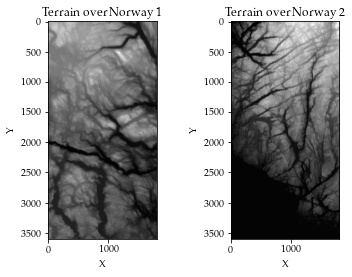

(3601, 1801)


In [3]:
# Load the terrain
terrain1_file = "SRTM_data_Norway_1.tif"
terrain2_file = "SRTM_data_Norway_2.tif"
terrain1 =  imread(f'{INPUT_DATA}{terrain1_file}')
terrain2 = imread(f'{INPUT_DATA}{terrain2_file}')

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1, cmap='gray')
ax2.title.set_text("Terrain over Norway 2")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}{EX6}terrain_data.pdf")
plt.show()
print(terrain1.shape)

## 6.0.1 Resizeing the terrain image
For computational purpose, we resize the terrain image to have a resonable amount of datapoints for our least sqaure models.

360
180


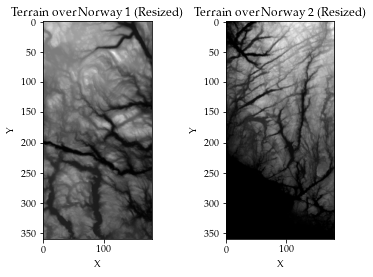

1161


In [4]:
rescale_factor = 0.1
ySize = int(terrain1.shape[0] * rescale_factor); print(ySize)
xSize = int(terrain1.shape[1] * rescale_factor); print(xSize)
terrain1Resized = cv2.resize(terrain1, (xSize, ySize))
terrain2Resized = cv2.resize(terrain2, (xSize, ySize))

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1 (Resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text("Terrain over Norway 2 (Resized)")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2Resized, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}{EX6}terrain_data_resized.pdf")
plt.show()
print(terrain1[0,0])

## 6.0.2 Creating image patches and Terrain data selection

## Methods

In [5]:
def create_img_patches(img, ySteps, xSteps):
    patches = []
    for y in range(0,img.shape[0], ySteps):
        for x in range(0,img.shape[1], xSteps):
            y_from = y; 
            y_to = y+ySteps; 
            x_from = x; 
            x_to = x+xSteps; 
            img_patch = img[y_from:y_to, x_from:x_to]        
            patches.append(img_patch)

    return patches

def patches_to_img(patches, ySteps, xSteps, nYpatches, nXpatches, plotImage=False):
    img = np.zeros((ySteps*nYpatches, xSteps*nXpatches))
    i = 0
    for y in range(0,img.shape[0], ySteps):
        for x in range(0,img.shape[1], xSteps):
            y_from = y; 
            y_to = y+ySteps; 
            x_from = x; 
            x_to = x+xSteps; 
            img[y_from:y_to, x_from:x_to] = patches[i]         
            i += 1
    
    if plotImage:
        plt.imshow(img, cmap='gray')
        plt.title("Reconstructed img")
        plt.show()
    return img

def plotTerrainPatches(patches, nYpatches, nXpatches, plotTitle="Terrain patches"):
    # Plotting terrain patches
    fig, ax = plt.subplots(nYpatches, nXpatches,figsize=(4,10))
    i=0
    for y in range(nYpatches):
        for x in range(nXpatches):
            ax[y,x].title.set_text(f"Patch{i}")
            ax[y,x].set_xlabel("X"); ax1.set_ylabel("Y")
            ax[y,x].imshow(patches[i], cmap='gray')
            i+=1
    
    fig.suptitle(f"{plotTitle}") # or plt.suptitle('Main title')
    plt.tight_layout()
    plt.savefig(f"{REPORT_FIGURES}{EX6}{plotTitle}.pdf")
    plt.show()

def createTerrainData(terrain, includeMeshgrid=True):
    z = np.array(terrain) 
    x = np.arange(0, z.shape[1])
    y = np.arange(0, z.shape[0])
    if includeMeshgrid:
        x, y = np.meshgrid(x,y)
    return x,y,z


60
60


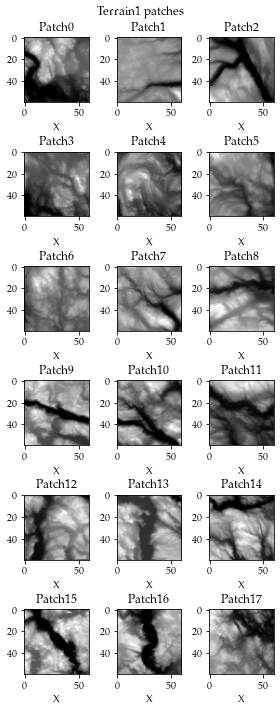

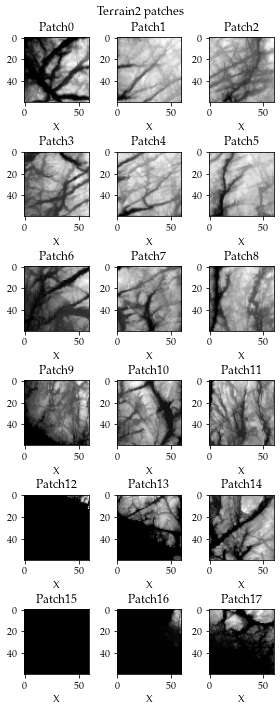

In [6]:
nXpatches = 3; nYpatches=6
y_steps = int(terrain2Resized.shape[0] / nYpatches); print(y_steps)
x_steps = int(terrain2Resized.shape[1] / nXpatches); print(x_steps)

patches_1 = create_img_patches(terrain1Resized, y_steps, x_steps)
plotTerrainPatches(patches_1, nYpatches, nXpatches, plotTitle="Terrain1 patches")

patches_2 = create_img_patches(terrain2Resized, y_steps, x_steps)
plotTerrainPatches(patches_2, nYpatches, nXpatches, plotTitle="Terrain2 patches")

# test
#img_reconstructed = patches_to_img(patches, y_steps, x_steps, nYpatches, nXpatches, plotImage=True)


## 6.0.3 Choosing of terrain patch and data creation
We look at the terrain data patches and choose which to create a fit for

In [7]:
img1 = patches_1[2]
img2 = patches_2[5]
x1, y1, z1 = createTerrainData(img1)
x2, y2, z2 = createTerrainData(img2)

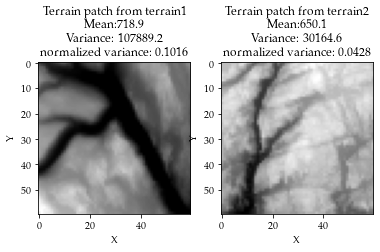

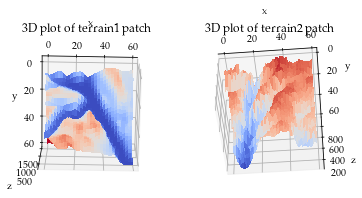

In [8]:
scaler1 = MinMaxScaler()
scaler1.fit(img1)
img1_normalized = scaler1.transform(img1)
norm_var1 = np.round(np.var(img1_normalized),decimals=4)

scaler2 = MinMaxScaler()
scaler2.fit(img2)
img2_normalized = scaler1.transform(img2)
norm_var2 = np.round(np.var(img2_normalized),decimals=4)

# 2D plot of the terrain patches
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text(f"Terrain patch from terrain1\nMean:\
{np.round(np.mean(img1),decimals=1)}\nVariance: {np.round(np.var(img1),decimals=1)}\n\
normalized variance: {norm_var1}")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(img1, cmap='gray')

ax2.title.set_text(F"Terrain patch from terrain2\nMean:\
{np.round(np.mean(img2),decimals=1)}\nVariance: {np.round(np.var(img2),decimals=1)}\n\
normalized variance: {norm_var2}")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(img2, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}{EX6}terrain_patch_to_fit_2D.pdf")
plt.show()

# 3D plot of the terrain patches
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.title.set_text(f"3D plot of terrain1 patch")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
#ax1.view_init(elev=60., azim=-120.0-70)
#ax1.view_init(elev=-60., azim=-120.0+30)
ax1.view_init(elev=-75., azim=-91)
ax1.plot_surface(x1, y1, z1, cmap=cm.coolwarm, linewidth = 0, antialiased=False)

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.title.set_text("3D plot of terrain2 patch")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")
#ax2.view_init(elev=60., azim=-120.0)
ax2.view_init(elev=-45., azim=-85.0)
ax2.plot_surface(x2, y2, z2, cmap=cm.coolwarm, linewidth = 0, antialiased=False)
plt.savefig(f"{REPORT_FIGURES}{EX6}terrain_patch_to_fit_3D.pdf")
plt.show()


## 6.0.4 Base input data for all exercises
We construct the data for least square regression based on preprocessed data. We also set up variables that will be used throughout the exercise.<br>
Terrain patch from terrain 1 is used as input for our models and our tests 

In [9]:
terrain_data = 1

if terrain_data == 1: # Choosing terrain1*
    x, y, z = x1, y1, z1.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z1

elif terrain_data == 2: # Choosing terrain2
    x, y, z = x2, y2, z2.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z2
    
z_flat = z.ravel(); z_flat = z_flat.reshape(-1,1)

# 6.1 OLS on data (Exercise1)

## Running OLS fit on the data as done in EX1 
Note that we exlude the calculation of CL for betas, since it is emedded within the model itself. See common.py for that code

Running OLS fitting on degree1
Running OLS fitting on degree2
Running OLS fitting on degree3
Running OLS fitting on degree4
Running OLS fitting on degree5
Running OLS fitting on degree6
Running OLS fitting on degree7
Running OLS fitting on degree8
Running OLS fitting on degree9
Running OLS fitting on degree10
Running OLS fitting on degree11
Running OLS fitting on degree12
Running OLS fitting on degree13
Running OLS fitting on degree14
Running OLS fitting on degree15
Running OLS fitting on degree16
Running OLS fitting on degree17
Running OLS fitting on degree18
Running OLS fitting on degree19
Running OLS fitting on degree20
Running OLS fitting on degree21
Running OLS fitting on degree22
Running OLS fitting on degree23
Running OLS fitting on degree24
Running OLS fitting on degree25
Running OLS fitting on degree26
Running OLS fitting on degree27
Running OLS fitting on degree28
Running OLS fitting on degree29
Running OLS fitting on degree30
Running OLS fitting on degree31
Running OLS fitti

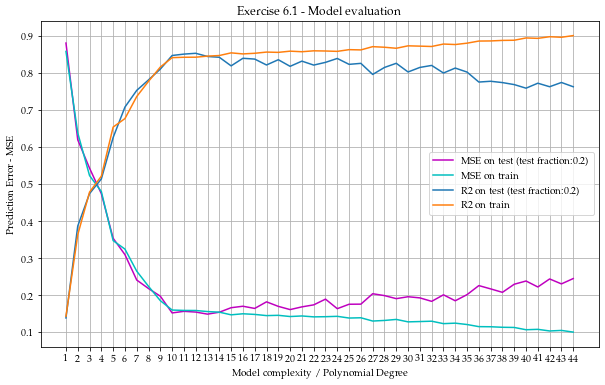

In [10]:
z_train_OLS = pd.DataFrame()
z_hat_train_OLS = pd.DataFrame()
z_test_OLS = pd.DataFrame()
z_hat_test_OLS = pd.DataFrame()
X_test_OLS = {}
df = pd.DataFrame()

degrees = 44
scale_X = True
scale_z = True
test_size = 0.2
fitted_models = []
for degree in range(1, degrees+1):
    print(f"Running OLS fitting on degree{degree}")
    X = create_X(x, y, degree) # Design Matrix

    # Scaling data and splitting it into training and test sets
    if scale_X:
        if scale_z:
            X_train, X_test, z_train, z_test = prepare_data(X, z_flat, test_size=test_size, shuffle=True, scale_X=True, scale_t=True, random_state=SEED_VALUE)
        else:
            X_train, X_test, z_train, z_test = prepare_data(X, z_flat, test_size=test_size, shuffle=True, scale_X=True, scale_t=False, random_state=SEED_VALUE)
    else:
         X_train, X_test, z_train, z_test = prepare_data(X, z_flat, test_size=test_size, shuffle=True, scale_X=False, scale_t=False, random_state=SEED_VALUE)
    
    #print(X_train[:, 0:1])
    # Model construction, fitting, and predictions
    model = OLS(degree=degree) # The model
    z_hat_train = model.fit(X_train, z_train) # Fitting the model and predict on training data
    z_hat_test = model.predict(X_test) # predict on test data
    
    # Evaluatation metrics
    #MSE_score_train = MSE(z_train, z_hat_train)
    #R2_score_train = R2(z_train, z_hat_train)
    #MSE_score_test = MSE(z_test, z_hat_test)
    #R2_score_test = R2(z_test, z_hat_test)
            
    # Filling up dataframes for train and test evaluation
    summary_df = model.summary()
    df = pd.concat([df,summary_df], axis=0)

    z_train_OLS[degree] = z_train.flatten()
    z_hat_train_OLS[degree] = z_hat_train.flatten()
    z_test_OLS[degree] = z_test.flatten()
    z_hat_test_OLS[degree] = z_hat_test.flatten()
    X_test_OLS[f"{degree}"] = X_test

    # Storing data for all degrees
    results = {"X_train":X_train, "X_test":X_test,"z_train":z_train, "z_test":z_test,
               "z_hat_train":z_hat_train, "z_hat_test":z_hat_test, "model":model, "summary":summary_df}
    #OLSrun.append(results)
    fitted_models.append(model)

# MSE calculations for all degrees
mse_scores_train = ((z_train_OLS - z_hat_train_OLS) ** 2).mean()
mse_scores_test = ((z_test_OLS - z_hat_test_OLS) ** 2).mean()
# R2 calculations for all degrees
R2_scores_train = 1 - ((z_train_OLS - z_hat_train_OLS) ** 2).sum() / ((z_train_OLS - z_train_OLS.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_OLS - z_hat_test_OLS) ** 2).sum() / ((z_test_OLS - z_test_OLS.mean())**2).sum()

# Plotting performance of OLS for different degrees
plt.figure(figsize=(10,6))
plt.plot(np.arange(1,degrees+1), mse_scores_test,"m", label=f'MSE on test (test fraction:{test_size})')
plt.plot(np.arange(1,degrees+1), mse_scores_train,"c", label='MSE on train')
plt.plot(np.arange(1,degrees+1), R2_scores_test, label=f'R2 on test (test fraction:{test_size})')
plt.plot(np.arange(1,degrees+1), R2_scores_train, label='R2 on train')
plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error - MSE")
plt.xticks(np.arange(1,degrees+1))
plt.grid(True)
plt.legend()
plt.title("Exercise 6.1 - Model evaluation")
plt.savefig(f"{REPORT_FIGURES}{EX6_1}OLS_evaluattion.pdf")
plt.show()

## Looking at $\beta$ values

df_degree.shape: (65, 6)


,degree,coeff name,coeff value,std error,CI lower,CI upper
0,10.0,$\beta$0,7.0016,3.1027,0.9203,13.0829
1,10.0,$\beta$1,30.51,2.9476,24.7326,36.2873
2,10.0,$\beta$2,-116.8847,55.3153,-225.3028,-8.4667
3,10.0,$\beta$3,-322.3718,31.4721,-384.0571,-260.6865
4,10.0,$\beta$4,-483.3549,54.2021,-589.5911,-377.1187
...,...,...,...,...,...,...
60,10.0,$\beta$60,-4493.1949,427.7683,-5331.6207,-3654.769
61,10.0,$\beta$61,-4145.2695,459.5023,-5045.894,-3244.6449
62,10.0,$\beta$62,3682.5208,514.9986,2673.1235,4691.9181
63,10.0,$\beta$63,-4786.169,647.7491,-6055.7574,-3516.5807


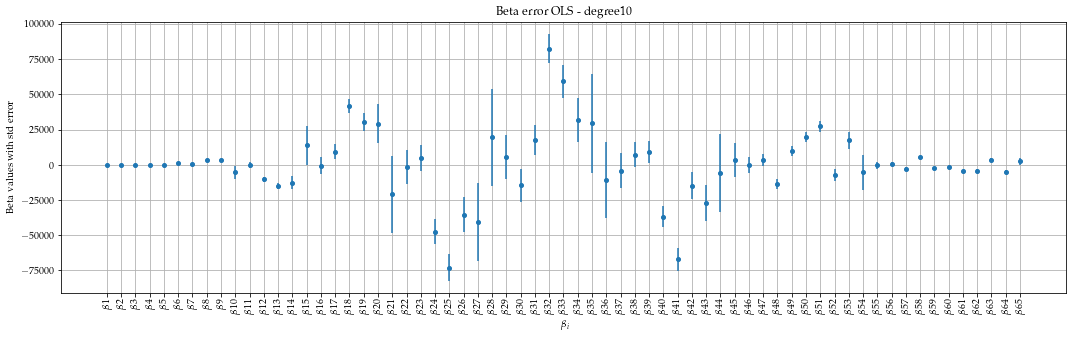

df_degree.shape: (77, 6)


,degree,coeff name,coeff value,std error,CI lower,CI upper
0,11.0,$\beta$0,5.0836,3.0886,-0.9701,11.1372
1,11.0,$\beta$1,35.003,3.422,28.2959,41.7101
2,11.0,$\beta$2,-34.8162,57.0415,-146.6175,76.9851
3,11.0,$\beta$3,-339.2416,32.3564,-402.6601,-275.8231
4,11.0,$\beta$4,-560.7465,60.3129,-678.9597,-442.5333
...,...,...,...,...,...,...
72,11.0,$\beta$72,0.0051,0.0143,-0.0229,0.0331
73,11.0,$\beta$73,-0.0012,0.0125,-0.0257,0.0233
74,11.0,$\beta$74,-0.0159,0.0112,-0.0379,0.0062
75,11.0,$\beta$75,-0.0011,0.0106,-0.0219,0.0197


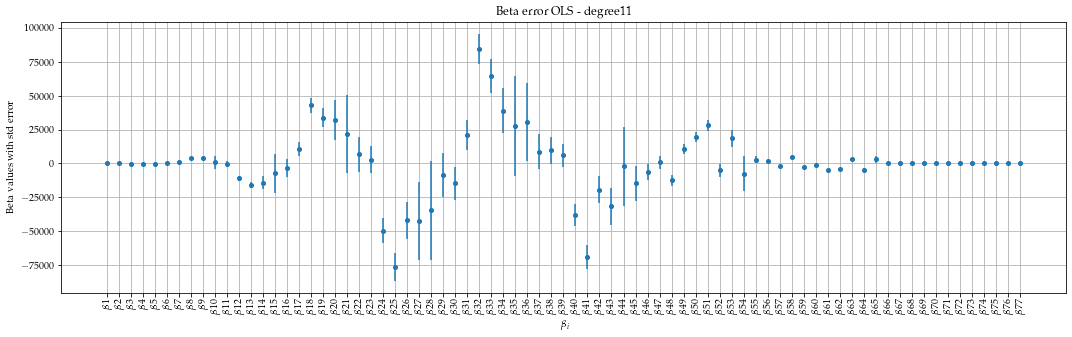

df_degree.shape: (90, 6)


,degree,coeff name,coeff value,std error,CI lower,CI upper
0,12.0,$\beta$0,5.5771,3.2199,-0.7338,11.8881
1,12.0,$\beta$1,31.3589,3.0565,25.3681,37.3496
2,12.0,$\beta$2,-77.1081,57.1817,-189.1843,34.9681
3,12.0,$\beta$3,-320.1755,32.0947,-383.081,-257.2699
4,12.0,$\beta$4,-504.3883,55.8431,-613.8409,-394.9358
...,...,...,...,...,...,...
85,12.0,$\beta$85,-0.0072,0.0078,-0.0224,0.008
86,12.0,$\beta$86,-0.011,0.0078,-0.0263,0.0043
87,12.0,$\beta$87,-0.0096,0.0078,-0.0248,0.0056
88,12.0,$\beta$88,0.0012,0.0078,-0.0141,0.0166


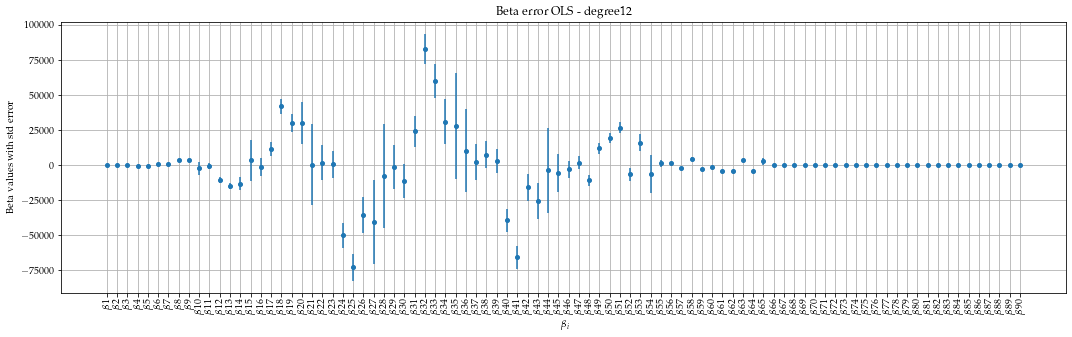

In [11]:
for deg in [10,11,12]:
    df_degree = df[df["degree"] == deg]
    print("df_degree.shape:",df_degree.shape)
    display(df_degree)
    df_degree.to_csv(f"{REPORT_DATA}{EX6_1}OLS_beta_error_degree{deg}.csv")
    fig = plot_beta_errors(df_degree, deg, fig=plt.figure(figsize=(18,5)))
    fig.savefig(f"{REPORT_FIGURES}{EX6_1}OLS_beta_error_degree{deg}.pdf")
    plt.show()

## Plotting predicted terrain using fitted degrees

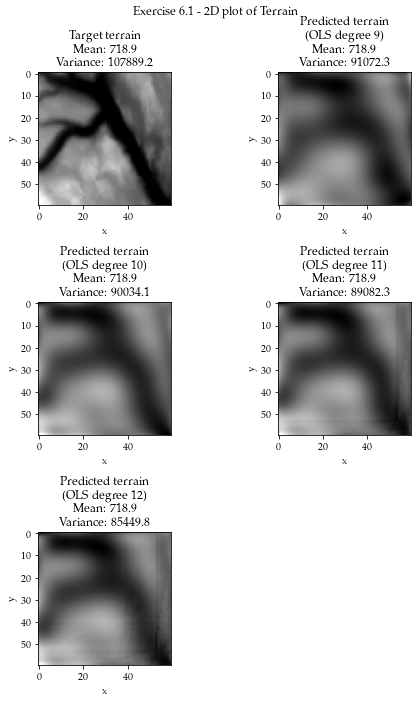

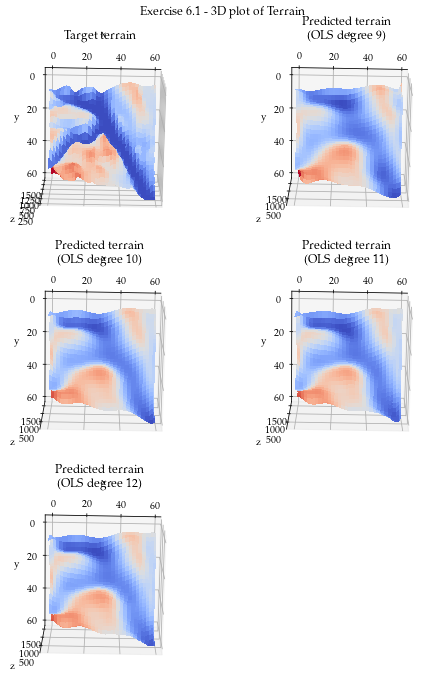

In [12]:
degrees_insight = [9,10,11,12]
z_hats = [z]
for deg in degrees_insight:
    X = create_X(x, y, deg) # Design Matrix 
    X = remove_intercept(X)
    X_scaled, _ = standard_scaling_single(X)
    z_scaled, z_scaler = standard_scaling_single(z.ravel().reshape(-1,1))
         
    # Using fitted model to predict the terrain patch 
    model = fitted_models[deg-1]
    z_hat = model.predict(X_scaled)

    z_hat = z_scaler.inverse_transform(z_hat.reshape(-1,1))
    #print(z_hat.shape)
    z_hat = z_hat.reshape((y_steps,x_steps))
    z_hats.append(z_hat)
z_hats = np.array(z_hats)

# 2D plot of predicted terrain patches
fig = plt.figure(figsize=(7,16))
j = 0
for i in range(z_hats.shape[0]):
    ax = fig.add_subplot(z_hats.shape[0],2,1+i)
    title = f"Predicted terrain\n(OLS degree {degrees_insight[j]})" if i>0 else "Target terrain"
    ax.title.set_text(f"{title}\nMean:\
    {np.round(np.mean(z_hats[i]),decimals=1)}\nVariance: {np.round(np.var(z_hats[i]),decimals=1)}")
    
    ax.set_xlabel("x"); ax.set_ylabel("y")
    surf2 = ax.imshow(z_hats[i], cmap='gray')
    j+=1 if i > 0 else j

plt.suptitle("Exercise 6.1 - 2D plot of Terrain")
plt.tight_layout()
plt.savefig(f"{REPORT_FIGURES}{EX6_1}target_terrain_and_OLS_prediction_2D.pdf")
plt.show()


# 3D plot of predicted terrain patches
fig = plt.figure(figsize=(7,16))
j = 0
for i in range(z_hats.shape[0]):
    ax = fig.add_subplot(z_hats.shape[0],2,1+i, projection='3d')
    title = f"Predicted terrain\n(OLS degree {degrees_insight[j]})" if i>0 else "Target terrain"
    ax.title.set_text(title)
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    #ax2.view_init(elev=60., azim=-120.0-70)
    ax.view_init(elev=-75., azim=-91)
    ax.plot_surface(x, y, z_hats[i], cmap=cm.coolwarm, linewidth = 0, antialiased=False)
    j+=1 if i > 0 else j

plt.suptitle("Exercise 6.1 - 3D plot of Terrain")
plt.tight_layout()
plt.savefig(f"{REPORT_FIGURES}{EX6_1}target_terrain_and_OLS_prediction_3D.pdf")
plt.show()

### Comments on the OLS fit to terrain data:
We scale the data since x, y, z is they are not between 0 to 1. Degree of 4 seems to yeild the best performance when fitting to the choosen terrain data.

# TODO:
#### This text may have to be adjusted
A degree of 4 or 5 seems to give a smooth surface for all the predicted patches. We find that the distortion and noise increase in the predicted image when the degree increases above 4-5 considering all patches. At higher degrees, some artifacts within the predicted patches also appear. In the predicted image with all patches, one can see some of the contours of the topographic structures in the image we try to approximate. However, the predicted image that is reconstructed from all the predicted patches is not very accurate. The task of this kind of problem is too complex for an OLS to manage. It may be that having smaller patches would increase the accuracy in reproducing the details incorporated in the input image. 

# 6.2 Bias-variance trade-off and resampling techniques on terrain data (Exercise2)

## 6.2.1 Exercise 2

# 6.3 Cross-validation as resampling techniques, adding more complexity (Exercise3)

## 6.4.1 Exercise 3

MSE: [0.16959657 0.16418504 0.16302233 0.16027981 0.16399023 0.16280355]
STD: [0.00691187 0.00831368 0.01263111 0.00846161 0.01224207 0.01403328]


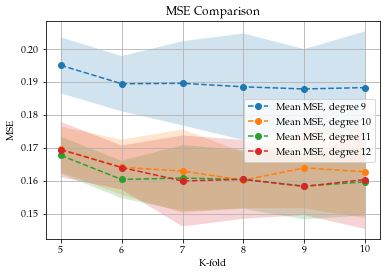

In [13]:
#%matplotlib
for degree in range(9,13):
    X = create_X(x,y,degree)
    #remove intercept: 
    X = X[:,1:]


    mean_folds_error = np.zeros(6)
    mean_folds_error_sk = np.zeros(6)

    mse_std_arr = np.zeros(6)
    for folds in range(5,11):
        

        implemented_scores = cross_val(k = folds, model = "OLS", X = X, z = z, degree=degree, shuffle=True, random_state = SEED_VALUE)
        mean_folds_error[folds-5] = np.mean(implemented_scores)
        mse_std_arr[folds-5] = np.std(implemented_scores)

    plt.plot(np.arange(5,11), mean_folds_error, "o--",  label = f"Mean MSE, degree {degree}")
    plt.fill_between(np.arange(5,11), mean_folds_error-mse_std_arr, mean_folds_error+mse_std_arr,  alpha = 0.2)
    plt.title(f"MSE Comparison")
    plt.xlabel("K-fold")
    plt.ylabel("MSE")
    #plt.ylim(0,2)
    plt.xticks(np.arange(5,11))
    plt.grid(True)
    plt.legend()
    plt.savefig(f"{REPORT_FIGURES}{EX6}mse_cv_fold_compare_degrees.pdf")

    if degree == 10:
        print(f"MSE: {mean_folds_error}")
        print(f"STD: {mse_std_arr}")

plt.show()

# 6.4 Ridge Regression on the Franke function with resampling (Exercise4)

## 6.4.1 Exercise 4

In [14]:
degree = 14
min_lambda = -9
max_lambda = 4
nlambdas = 500
lambdas = np.logspace(min_lambda,max_lambda, nlambdas)

test_mse = np.zeros((degree, nlambdas))
train_mse = np.zeros_like(test_mse)
model_list = np.empty_like(test_mse, dtype=object)
optimal_deg = 0
optimal_lmb = 0
lambda_degree = 0
best_mse = np.inf

for deg in range(1, degree+1):
    for lmb in range(len(lambdas)):

        X = create_X(x,y,n=deg)

        X_train, X_test, z_train, z_test = prepare_data(X, z_flat, 4155, scale_X=True, scale_t=True, skip_intercept=True)

        model = RidgeRegression(lambdas[lmb])
        z_hat_train = model.fit(X_train, z_train)
        z_hat_test = model.predict(X_test)

        test_mse[deg-1,lmb] = MSE(z_test, z_hat_test)
        train_mse[deg-1, lmb] = MSE(z_train, z_hat_train)
        model_list[deg-1,lmb] = model
        
        if test_mse[deg-1,lmb] < best_mse:
            best_mse = test_mse[deg-1, lmb]
            optimal_deg = deg
            optimal_lmb = lambdas[lmb]
            lambda_degree = lmb

print(best_mse)
print(optimal_lmb)
print(optimal_deg)
print(train_mse[deg-1, lmb])
optimal_model = model_list[deg-1, lambda_degree]

0.17005359936234143
1e-09
13
0.6845527119411376


In [15]:
%matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.title.set_text("Plot of the Search Landscape")
ax.set_xlabel("Polynomial degree"); ax.set_ylabel("Lambda index"); ax.set_zlabel("MSE")
#ax.set_yticklabels(f"{np.log10(lambdas[i])}" for i in np.linspace(0,499,6,dtype=int))
ax.set_xticklabels(f"{deg-2}" for deg in range(1, degree+2,2))
degs, lambs = np.meshgrid(range(degree), range(nlambdas))
print(degs.shape)
print(lambs.shape)
print(test_mse.shape)
surf = ax.plot_surface(degs, lambs, test_mse.swapaxes(0,1), cmap=cm.coolwarm)
ax.view_init(elev=14., azim=-58.)
ax.scatter(optimal_deg-1, lambda_degree, best_mse, c='r', marker='o', s=100)
plt.savefig(f"{REPORT_FIGURES}{EX6}search_landscape_ridge.pdf")

Using matplotlib backend: TkAgg


/tmp/ipykernel_524548/2154382593.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(f"{deg-2}" for deg in range(1, degree+2,2))


(500, 14)
(500, 14)
(14, 500)


In [16]:
"""
import matplotlib.ticker as mticker
%matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.title.set_text("Plot of the Search Landscape")
ax.set_xlabel("Polynomial degree"); ax.set_ylabel("Lambda index"); ax.set_zlabel("MSE")
#ax.set_yticklabels(f"{np.log10(lambdas[i])}" for i in np.linspace(0,499,6,dtype=int))
#ax.set_xticklabels(f"{deg-2}" for deg in range(1, degree+3,2))

degs, lambs = np.meshgrid(range(degree), range(nlambdas))
print(degs.shape)
print(lambs.shape)
print(test_mse.shape)
surf = ax.plot_surface(degs, lambs, test_mse.swapaxes(0,1), cmap=cm.coolwarm)
ax.view_init(elev=14., azim=-58.)
ax.scatter(15, 15, best_mse, c='r', marker='o', s=100)
plt.savefig(f"{REPORT_FIGURES}{EX6}search_landscape_ridge.pdf")
"""

'\nimport matplotlib.ticker as mticker\n%matplotlib\nfig = plt.figure()\nax = fig.add_subplot(111, projection=\'3d\')\nax.title.set_text("Plot of the Search Landscape")\nax.set_xlabel("Polynomial degree"); ax.set_ylabel("Lambda index"); ax.set_zlabel("MSE")\n#ax.set_yticklabels(f"{np.log10(lambdas[i])}" for i in np.linspace(0,499,6,dtype=int))\n#ax.set_xticklabels(f"{deg-2}" for deg in range(1, degree+3,2))\n\ndegs, lambs = np.meshgrid(range(degree), range(nlambdas))\nprint(degs.shape)\nprint(lambs.shape)\nprint(test_mse.shape)\nsurf = ax.plot_surface(degs, lambs, test_mse.swapaxes(0,1), cmap=cm.coolwarm)\nax.view_init(elev=14., azim=-58.)\nax.scatter(15, 15, best_mse, c=\'r\', marker=\'o\', s=100)\nplt.savefig(f"{REPORT_FIGURES}{EX6}search_landscape_ridge.pdf")\n'

## Ridge with cross-validatation:

In [17]:
from sklearn.metrics import mean_squared_error
degree = 10
min_lambda = -9
max_lambda = 4
nlambdas = 10
lambdas = np.logspace(min_lambda,max_lambda, nlambdas)
k_fold = 10

X = create_X(x,y,degree)
#remove intercept: 
X = X[:,1:]
mean_mse = np.zeros(nlambdas)
mse_std_arr = np.zeros_like(mean_mse)
lambdas = np.logspace(min_lambda, max_lambda, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]
    
    implemented_scores = cross_val(k = k_fold, model = "Ridge", X = X, z = z, degree=degree,lmb=lmb, shuffle=True, random_state = SEED_VALUE)
    mean_mse[i]= np.mean(implemented_scores)
    mse_std_arr[i]= np.std(implemented_scores)

plt.plot(np.linspace(min_lambda,max_lambda,nlambdas), mean_mse, "o--",  label = f"Mean MSE,{k_fold}-fold")
plt.fill_between(np.linspace(min_lambda,max_lambda,nlambdas), mean_mse-mse_std_arr, mean_mse+mse_std_arr,  alpha = 0.2)

plt.title(f"Estimated Cross-val MSE for Ridge at degree {degree}")
plt.xlabel("'log10(lambda)'")
plt.ylabel("MSE")
#plt.ylim(0,2)
#plt.xticks(np.logspace(min_lambda,max_lambda,nlambdas))
plt.grid(True)
plt.legend()
# plt.savefig(f"{REPORT_FIGURES}{EX6}mse_cv_{k_fold}_fold.pdf")
plt.show()

# 6.5. Lasso Regression on the Franke function with resampling (Exercise5)

## 6.5.1 Exercise 5

In [18]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Search Landscape Lasso

In [19]:
degree = 14
min_lambda = -7
max_lambda = 2
nlambdas = 100
lambdas = np.logspace(min_lambda,max_lambda, nlambdas)

test_mse = np.zeros((degree, nlambdas))
train_mse = np.zeros_like(test_mse)
model_list = np.empty_like(test_mse, dtype=object)
optimal_deg = 0
optimal_lmb = 0
lambda_degree = 0
best_mse = np.inf

for deg in range(1, degree+1):
    for lmb in range(len(lambdas)):

        X = create_X(x,y,n=deg)

        X_train, X_test, z_train, z_test = prepare_data(X, z_flat, 4155, scale_X=True, scale_t=True, skip_intercept=True)

        model = lm.Lasso(lambdas[lmb], fit_intercept=False, random_state=4155)
        model.fit(X_train, z_train)
        z_hat_train = model.predict(X_train)
        z_hat_test = model.predict(X_test)

        test_mse[deg-1,lmb] = MSE(z_test, z_hat_test)
        train_mse[deg-1, lmb] = MSE(z_train, z_hat_train)
        model_list[deg-1,lmb] = model
        
        if test_mse[deg-1,lmb] < best_mse:
            best_mse = test_mse[deg-1, lmb]
            optimal_deg = deg
            optimal_lmb = lambdas[lmb]
            lambda_degree = lmb

print(best_mse)
print(optimal_lmb)
print(optimal_deg)
print(train_mse[deg-1, lmb])
optimal_model = model_list[deg-1, lambda_degree]

/usr/lib/python3.9/tkinter/__init__.py:814: MatplotlibDeprecationWarning: The 'renderer' parameter of do_3d_projection() was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  func(*args)
Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.9/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/usr/lib/python3.9/tkinter/__init__.py", line 814, in callit
    func(*args)
  File "/usr/lib/python3.9/site-packages/matplotlib/backends/_backend_tk.py", line 240, in idle_draw
    self.draw()
  File "/usr/lib/python3.9/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super().draw()
  File "/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py", line 406, in draw
    self.figure.draw(self.renderer)
  File "/usr/lib/python3.9/site-packages/matplotlib/artist.py", line 74, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
  File "/usr/lib/python3.9/sit

0.3734046691683801
1e-07
9
1.0000000000000002


In [20]:
%matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.title.set_text("Plot of the Search Landscape")
ax.set_xlabel("Polynomial degree"); ax.set_ylabel("Lambda index"); ax.set_zlabel("MSE")
#ax.set_yticklabels(f"{np.log10(lambdas[i])}" for i in np.linspace(0,499,6,dtype=int))
ax.set_xticklabels(f"{deg-2}" for deg in range(1, degree+2,2))
degs, lambs = np.meshgrid(range(degree), range(nlambdas))
print(degs.shape)
print(lambs.shape)
print(test_mse.shape)
surf = ax.plot_surface(degs, lambs, test_mse.swapaxes(0,1), cmap=cm.coolwarm)
ax.view_init(elev=14., azim=-58.)
ax.scatter(optimal_deg-1, lambda_degree, best_mse, c='r', marker='o', s=100)
plt.savefig(f"{REPORT_FIGURES}{EX6}search_landscape_lasso.pdf")

Using matplotlib backend: TkAgg
(100, 14)
(100, 14)
(14, 100)


/tmp/ipykernel_524548/1956494544.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(f"{deg-2}" for deg in range(1, degree+2,2))


## Cross-Validation with Lasso: 

In [26]:
from sklearn.metrics import mean_squared_error
degree = 9
min_lambda = -7
max_lambda = 2
nlambdas = 20
lambdas = np.logspace(min_lambda,max_lambda, nlambdas)


X = create_X(x,y,degree)
#remove intercept: 
X = X[:,1:]
mean_mse = np.zeros(nlambdas)
mse_std_arr = np.zeros_like(mean_mse)
lambdas = np.logspace(min_lambda, max_lambda, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]
    
    implemented_scores = cross_val(k = k_fold, model = "Lasso", X = X, z = z, degree=degree,lmb=lmb, shuffle=True, random_state = SEED_VALUE)
    mean_mse[i]= np.mean(implemented_scores)
    mse_std_arr[i]= np.std(implemented_scores)

plt.plot(np.linspace(min_lambda,max_lambda,nlambdas), mean_mse, "o--",  label = f"Mean MSE,{k_fold}-fold")
plt.fill_between(np.linspace(min_lambda,max_lambda,nlambdas), mean_mse-mse_std_arr, mean_mse+mse_std_arr,  alpha = 0.2)

plt.title(f"Estimated Cross-val MSE for Lasso at degree {degree}")
plt.xlabel("'log10(lambda)'")
plt.ylabel("MSE")
#plt.ylim(0,2)
#plt.xticks(np.logspace(min_lambda,max_lambda,nlambdas))
plt.grid(True)
plt.legend()
plt.savefig(f"{REPORT_FIGURES}{EX6}mse_cv_{k_fold}_fold_lasso.pdf")
plt.show()

# 6.6 Extras

In [22]:
# This cell is used to evaluate best degree for all patches
n_xpatches = 9; n_ypatches=18
y_steps = int(terrain1Resized.shape[0] / n_ypatches); print(y_steps)
x_steps = int(terrain1Resized.shape[1] / n_xpatches); print(x_steps)

patches_1_test = create_img_patches(terrain1Resized, y_steps, x_steps)
#plotTerrainPatches(patches_1_test, n_ypatches, n_xpatches, plotTitle="Terrain1 patches")



np.random.seed(SEED_VALUE) 
z_flat = z.ravel(); z_flat = z_flat.reshape(-1,1)
z_train_OLS = pd.DataFrame()
z_hat_train_OLS = pd.DataFrame()
z_test_OLS = pd.DataFrame()
z_hat_test_OLS = pd.DataFrame()
X_test_OLS = {}
df = pd.DataFrame()

degrees = 22
scale_X = True
scale_z = True
test_size = 0.2
fitted_models = []
plot = False
for patch in patches_1_test:
    for degree in range(1, degrees+1):
        #print(f"Running OLS fitting on degree{degree}")
        xpatch, ypatch, zpatch = createTerrainData(patch)
        zpatch = zpatch.ravel().reshape(-1,1)

        X = create_X(xpatch, ypatch, degree) # Design Matrix

        # Scaling data and splitting it into training and test sets
        if scale_X:
            if scale_z:
                X_train, X_test, z_train, z_test = prepare_data(X, zpatch, test_size=test_size, shuffle=True, scale_X=True, scale_t=True, random_state=SEED_VALUE)
            else:
                X_train, X_test, z_train, z_test = prepare_data(X, zpatch, test_size=test_size, shuffle=True, scale_X=True, scale_t=False, random_state=SEED_VALUE)
        else:
            X_train, X_test, z_train, z_test = prepare_data(X, zpatch, test_size=test_size, shuffle=True, scale_X=False, scale_t=False, random_state=SEED_VALUE)
        
        #print(X_train[:, 0:1])
        # Model construction, fitting, and predictions
        model = OLS(degree=degree) # The model
        z_hat_train = model.fit(X_train, z_train) # Fitting the model and predict on training data
        z_hat_test = model.predict(X_test) # predict on test data
        
        # Evaluatation metrics
        MSE_score_train = MSE(z_train, z_hat_train)
        R2_score_train = R2(z_train, z_hat_train)
        MSE_score_test = MSE(z_test, z_hat_test)
        R2_score_test = R2(z_test, z_hat_test)
                
        # Filling up dataframes for train and test evaluation
        z_train_OLS[degree] = z_train.flatten()
        z_hat_train_OLS[degree] = z_hat_train.flatten()
        z_test_OLS[degree] = z_test.flatten()
        z_hat_test_OLS[degree] = z_hat_test.flatten()
        X_test_OLS[f"{degree}"] = X_test

   
        fitted_models.append(model)

    # MSE calculations for all degrees
    mse_scores_train = ((z_train_OLS - z_hat_train_OLS) ** 2).mean()
    mse_scores_test = ((z_test_OLS - z_hat_test_OLS) ** 2).mean()
    # R2 calculations for all degrees
    R2_scores_train = 1 - ((z_train_OLS - z_hat_train_OLS) ** 2).sum() / ((z_train_OLS - z_train_OLS.mean())**2).sum() 
    R2_scores_test = 1 - ((z_test_OLS - z_hat_test_OLS) ** 2).sum() / ((z_test_OLS - z_test_OLS.mean())**2).sum()

    # Plotting performance of OLS for different degrees
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(np.arange(1,degrees+1), mse_scores_test,"m", label=f'MSE on test (test fraction:{test_size})')
        plt.plot(np.arange(1,degrees+1), mse_scores_train,"c", label='MSE on train')
        # plt.plot(np.arange(1,degrees+1), R2_scores_test, label=f'R2 on test (test fraction:{test_size})')
        # plt.plot(np.arange(1,degrees+1), R2_scores_train, label='R2 on train')
        plt.xlabel("Model complexity / Polynomial Degree")
        plt.ylabel("Prediction Error - MSE")
        plt.xticks(np.arange(1,degrees+1))
        plt.grid(True)
        plt.legend()
        plt.title("Exercise 6.1 - Model evaluation")
        plt.show()

20
20


# OLS fit on the whole terrain1 data
Using degree 8 for all models for alle patches

In [23]:
n_xpatches = 9; n_ypatches=18
y_steps = int(terrain1Resized.shape[0] / n_ypatches); print(y_steps)
x_steps = int(terrain1Resized.shape[1] / n_xpatches); print(x_steps)

patches_1_test = create_img_patches(terrain1Resized, y_steps, x_steps)
#plotTerrainPatches(patches_1_test, n_ypatches, n_xpatches, plotTitle="Terrain1 patches")

np.random.seed(SEED_VALUE) 
z_flat = z.ravel(); z_flat = z_flat.reshape(-1,1)
z_train_OLS = pd.DataFrame()
z_hat_train_OLS = pd.DataFrame()
z_test_OLS = pd.DataFrame()
z_hat_test_OLS = pd.DataFrame()
X_test_OLS = {}
df = pd.DataFrame()

degree = 8

# Fitting the model 
scale_X = True
scale_z = True
test_size = 0.2
fitted_models = []
for patch in patches_1_test:
    xpatch, ypatch, zpatch = createTerrainData(patch)
    zpatch = zpatch.ravel().reshape(-1,1)
    X = create_X(xpatch, ypatch, degree) # Design Matrix

    # Scaling data and splitting it into training and test sets
    if scale_X:
        if scale_z:
            X_train, X_test, z_train, z_test = prepare_data(X, zpatch, test_size=test_size, shuffle=True, scale_X=True, scale_t=True, random_state=SEED_VALUE)
        else:
            X_train, X_test, z_train, z_test = prepare_data(X, zpatch, test_size=test_size, shuffle=True, scale_X=True, scale_t=False, random_state=SEED_VALUE)
    else:
        X_train, X_test, z_train, z_test = prepare_data(X, zpatch, test_size=test_size, shuffle=True, scale_X=False, scale_t=False, random_state=SEED_VALUE)
    
    #print(X_train[:, 0:1])
    # Model construction, fitting, and predictions
    model = OLS(degree=degree) # The model
    z_hat_train = model.fit(X_train, z_train) # Fitting the model and predict on training data
    fitted_models.append(model)
    

# prediction patches
z_hats = []
for i, patch in enumerate(patches_1_test):
    #z_scaled, _ = standard_scaling_single(patch.ravel().reshape(-1,1))
    xpatch, ypatch, zpatch = createTerrainData(patch)
    X = create_X(xpatch, ypatch, degree) # Design Matrix
    X = remove_intercept(X)
    X_scaled, _ = standard_scaling_single(X)
    model = fitted_models[i]
    z_hat = model.predict(X_scaled)
    z_hats.append(z_hat.reshape((y_steps,x_steps)))

    
terrain1_predicted = patches_to_img(z_hats, y_steps, x_steps, n_ypatches, n_xpatches, plotImage=False)

# Plotting predicted patches
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text(f"Terrain1 (resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text(f"Terrain1 - OLS predicted")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain1_predicted, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}{EX6}terrain_OLS_pred_all_patches_at_degree{degree}.pdf")
plt.show()

20
20


# Trying to overfit to terrain for all patches

In [24]:

testDegree = 150
testDegree = 10
patches_1_preds = []
X = create_X(x1, y1, testDegree) # Design Matrix
X_scaled, _ = standard_scaling_single(X)

for patch in tqdm(patches_1_test):
    z_scaled, _ = standard_scaling_single(patch.ravel().reshape(-1,1))
    model = OLS(degree=testDegree) # The model
    z_hat_train = model.fit(X_scaled, z_scaled) # Fitting the model and predict on training data
    z_hat = z_hat_train.reshape((y_steps,x_steps))
    patches_1_preds.append(z_hat)
    
terrain1_predicted = patches_to_img(patches_1_preds, y_steps, x_steps, nYpatches, nXpatches, plotImage=False)

# Plotting predicted patches
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text(f"Terrain1 (resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text(f"Terrain1 - OLS predicted")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain1_predicted, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}{EX6_1}terrain_and_all_patches_predicted_at_degree{testDegree}.pdf")
plt.show()

  0%|          | 0/162 [00:00<?, ?it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 400 is different from 3600)

/usr/lib/python3.9/tkinter/__init__.py:814: MatplotlibDeprecationWarning: The 'renderer' parameter of do_3d_projection() was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  func(*args)
Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.9/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/usr/lib/python3.9/tkinter/__init__.py", line 814, in callit
    func(*args)
  File "/usr/lib/python3.9/site-packages/matplotlib/backends/_backend_tk.py", line 240, in idle_draw
    self.draw()
  File "/usr/lib/python3.9/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super().draw()
  File "/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py", line 406, in draw
    self.figure.draw(self.renderer)
  File "/usr/lib/python3.9/site-packages/matplotlib/artist.py", line 74, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
  File "/usr/lib/python3.9/sit

# Tests of dimensions image reduction and patches

In [ ]:
i = 1
value = 180
while True:
    i += 1
    if((value % i)==0):
        print(f"value:{value / i} at i:{i}")
    if(i>=value):
        break

In [ ]:
i = 1
value = 360
while True:
    i += 1
    if((value % i)==0):
        print(f"value:{value / i} at i:{i}")
    if(i>=value):
        break